In [1]:
from dask.distributed import Client, progress

client = Client()
client

Client Scheduler: tcp://127.0.0.1:58362 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 17.18 GB


In [2]:
import random
from operator import attrgetter
import time
import copy as cp
import dask
import pandas as pd

In [3]:
import Utileria as utest

In [4]:
query = "SELECT * FROM trabajo.fuerza_ventas; "
df = utest.get_data(query)
#print(df.head(10))

Selecting rows from table using cursor.fetchall
PostgreSQL connection is closed


In [5]:
class Particula():

    list_CaminoActual = []
    list_MejorCamino = []
    nbr_CostoCaminoActual = 0
    nbr_CostoMejorCamino = 0
    velocidad = []

    def __init__(self, par_camino, par_costo):

        self.list_CaminoActual = par_camino
        self.list_MejorCamino = par_camino
        self.nbr_CostoCaminoActual = par_costo
        self.nbr_CostoMejorCamino = par_costo
        self.velocidad = []

In [6]:
class Grafo():

    dict_Nodos = {}
    conj_Nodos = set()  # No hay repeticiones
    nbr_CantNodos = 0
    df_Grafo = None

    def __init__(self, par_df):
        self.df_Grafo = par_df
        self.GenerarGrafo()
        self.nbr_CantNodos = len(self.conj_Nodos)

    def GenerarGrafo(self):

        # Barremos las filas del data frame para generar el grafo
        for fila in self.df_Grafo:
            # Las distacias son las mismas en ambos sentidos
            self.AgregarNodoAGrafo(fila[0], fila[1], fila[2])
            self.AgregarNodoAGrafo(fila[1], fila[0], fila[2])

    def AgregarNodoAGrafo(self, par_Origen, par_Destino, par_Costo):

        if not self.ExisteNodo(par_Origen, par_Destino):
            self.dict_Nodos[(par_Origen, par_Destino)] = par_Costo
            self.conj_Nodos.add(par_Origen)
            self.conj_Nodos.add(par_Destino)

    def ExisteNodo(self, par_Origen, par_Destino):
        if (par_Origen, par_Destino) in self.dict_Nodos:
            return True
        else:
            return False

    def MostrarGrafo(self):
        print('Grafo:\n')
        for Nodo in self.dict_Nodos:
            print('%d conectado con: %d. Costo: %d' % (Nodo[0], Nodo[1], self.dict_Nodos[Nodo]))

    def CostoDelCamino(self, camino):

        nbr_CostoTotal = 0
        for i in range(self.nbr_CantNodos - 1):
            nbr_CostoTotal += self.dict_Nodos[(camino[i], camino[i+1])]

        nbr_CostoTotal += self.dict_Nodos[(camino[self.nbr_CantNodos - 1], camino[0])]
        return nbr_CostoTotal

    def GenerarCaminosAleatorios(self, max_size):

        list_CaminosAleatorio, list_Nodos = [], list(self.conj_Nodos)

        initial_vertice = random.choice(list_Nodos)

        list_Nodos.remove(initial_vertice)
        list_Nodos.insert(0, initial_vertice)

        for i in range(max_size):
            list_temp = list_Nodos[1:]
            random.shuffle(list_temp)
            list_temp.insert(0, initial_vertice)

            if list_temp not in list_CaminosAleatorio:
                list_CaminosAleatorio.append(list_temp)

        return list_CaminosAleatorio

In [7]:
class ParticleSwarm():

    # Atributos generales para la ejecución
    df_Datos = ''
    str_TipoEjec = ''

    # Hiperparámetros del algoritmo
    nbr_Iteraciones = 0
    nbr_CantPartic = 0
    nbr_Alfa = 0
    nbr_Beta = 0

    # Atributos de resultados de la ejecución
    nbr_TiempoEjec = 0
    nbr_MejorCosto = 0
    lst_MejorCamino = []

    # Atributo auxiliar
    list_Particulas = []

    def __init__(self, par_Datos, par_TipoEjec, par_HiperParam):

        # Datos y tipo de ejecución
        self.df_Datos = par_Datos
        self.str_TipoEjec = par_TipoEjec

        # Hiperparámetros del algoritmo
        self.nbr_Iteraciones = par_HiperParam.get('Iteraciones')
        self.nbr_CantPartic = par_HiperParam.get('Particulas')
        self.nbr_Alfa = par_HiperParam.get('Alfa')
        self.nbr_Beta = par_HiperParam.get('Beta')

        #################

        self.Grafo = Grafo(self.df_Datos)
        list_CaminosAleatorios = self.Grafo.GenerarCaminosAleatorios(self.nbr_CantPartic)
        for list_CaminoAleatorio in list_CaminosAleatorios:
            particula = Particula(list_CaminoAleatorio, self.Grafo.CostoDelCamino(list_CaminoAleatorio))
            self.list_Particulas .append(particula)

        # updates "size_population"
        self.nbr_CantPartic = len(self.list_Particulas)

    def Ejecutar(self):

        # Tomamos la hora de inicio
        tm_inicio = time.time()

        # Se corre el algorimto secuencial o en paralelo según los parámetros
        if self.str_TipoEjec == 'SEQ':
            self.Secuencial()
        elif self.str_TipoEjec == 'PAR':
            self.Paralelo()
            
        self.lst_MejorCamino = self.obj_MejorParticula.list_MejorCamino
        self.nbr_MejorCosto = self.obj_MejorParticula.nbr_CostoMejorCamino

        # Se toma la hora de fin del algoritmo, y se almacena la duración
        tm_final = time.time()
        self.nbr_TiempoEjec = tm_final - tm_inicio

    def Secuencial(self):

        for t in range(self.nbr_Iteraciones):

            self.obj_MejorParticula = min(self.list_Particulas, key=attrgetter('nbr_CostoMejorCamino'))

            for particula in self.list_Particulas:

                particula = self.ProcesoXParticula(particula, self.obj_MejorParticula)

    def Paralelo(self):

        # Por ejemplo
        for t in range(self.nbr_Iteraciones):

            self.obj_MejorParticula = min(self.list_Particulas, key=attrgetter('nbr_CostoMejorCamino'))

            list_Particulas_Temp = []
            for particula in self.list_Particulas:

                dask_Particula = self.ProcesoXParticulaParalelo(particula, self.obj_MejorParticula)
                list_Particulas_Temp.append(dask_Particula)

            dask_Dummy1 = self.JuntarParticulas(list_Particulas_Temp)
            dask_Dummy2 = dask_Dummy1.compute()
            list_Final = dask_Dummy2[0]
            self.list_Particulas = list_Final

    @dask.delayed
    def JuntarParticulas(self, *argv):
        return argv

    @dask.delayed
    def ProcesoXParticulaParalelo(self, particle, par_gbest):
        return self.ProcesoXParticula(particle, par_gbest)

    def ProcesoXParticula(self, particula, par_gbest):

        # time.sleep(.01)
        del particula.velocidad[:]

        list_VelocidadTemp = []
        list_MejorCaminoGlob = cp.copy(self.obj_MejorParticula.list_MejorCamino)
        list_MejorCaminoPart = particula.list_MejorCamino[:]
        list_CaminoParticula = particula.list_CaminoActual[:]

        list_VelocidadTemp_p = self.Swap(list_CaminoParticula, list_MejorCaminoPart, self.nbr_Alfa)

        list_VelocidadTemp_g = self.Swap(list_CaminoParticula, list_MejorCaminoGlob, self.nbr_Beta)

        list_VelocidadTemp_t = self.JuntarListasSwaps(list_VelocidadTemp_p, list_VelocidadTemp_g)
        list_VelocidadTemp = list_VelocidadTemp_t

        particula.velocidad = list_VelocidadTemp

        # Generación de nuevo camino para la particula
        for tup_Swarm in list_VelocidadTemp:

            if random.random() <= tup_Swarm[2]:
                aux = list_CaminoParticula[tup_Swarm[0]]
                list_CaminoParticula[tup_Swarm[0]] = list_CaminoParticula[tup_Swarm[1]]
                list_CaminoParticula[tup_Swarm[1]] = aux

        particula.list_CaminoActual = list_CaminoParticula
        nbr_CostoCaminoActual = self.Grafo.CostoDelCamino(list_CaminoParticula)
        particula.nbr_CostoCaminoActual = nbr_CostoCaminoActual

        if nbr_CostoCaminoActual < particula.nbr_CostoMejorCamino:
            particula.list_MejorCamino = list_CaminoParticula
            particula.nbr_CostoMejorCamino = nbr_CostoCaminoActual

        return particula

    # @dask.delayed
    def Swap(self, par_CaminoParticula, par_MejorCamino, par_AlphaBeta):
        list_VelocidadTemp = []
        for i in range(self.Grafo.nbr_CantNodos):
            if par_CaminoParticula[i] != par_MejorCamino[i]:

                tup_Swarm = (i, par_MejorCamino.index(par_CaminoParticula[i]), par_AlphaBeta)
                list_VelocidadTemp.append(tup_Swarm)

                # Hacemos el intercambio
                aux = par_MejorCamino[tup_Swarm[0]]
                par_MejorCamino[tup_Swarm[0]] = par_MejorCamino[tup_Swarm[1]]
                par_MejorCamino[tup_Swarm[1]] = aux

        return list_VelocidadTemp

    # @dask.delayed
    def JuntarListasSwaps(self, list1, list2):
        total = list1 + list2
        return total

In [8]:
df.head()

,fza_ventas,no_cliente,lat_destino,lon_destino,id_origen,estado,lat_origen,lon_origen
0,123,10295095,25.7848,-100.398,11388,Nuevo León,25.7789,-100.387
1,123,1010290203,25.7839,-100.395,11388,Nuevo León,25.7789,-100.387
2,123,1010290279,25.7779,-100.400,11388,Nuevo León,25.7789,-100.387
3,123,1010291206,25.7624,-100.395,11388,Nuevo León,25.7789,-100.387
4,123,1010291416,25.7733,-100.410,11388,Nuevo León,25.7789,-100.387


In [9]:
fv = 20240
#1143 3 puntos
#94459 6 puntos
#17147 9 puntos
#20240 2 puntos dobles
dm,df2 = utest.distance_matrix(df, fv)

In [10]:
df2

,fza_ventas,id,lat,lon,posicion
1116,20240,11326,25.6409,-100.089,1
1116,20240,1008232009,25.5881,-100.012,2
1117,20240,1008232105,25.5797,-100.009,3
1118,20240,1008232217,25.5689,-100.028,4
1119,20240,1008232222,25.5773,-100.014,5
1120,20240,1008232223,25.5729,-100.009,6
1121,20240,1008232500,25.6323,-100.035,7
1122,20240,1008233352,25.5782,-100.010,8
1123,20240,1020211168,25.5772,-100.017,9
1124,20240,1020268099,25.5780,-100.016,10


In [11]:
rutas = pd.DataFrame(index=range(10),columns=['Costo', 'Tiempo', 'Ruta', 'Ruta2'])
rutas

,Costo,Tiempo,Ruta,Ruta2
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN


In [12]:
######################################## Código para hacer pruebas ########################################

# Para recibir este dataframe, sólo dime en qué formato me lo mandas, y
# adapto la clase para leerlo.
#df_Dummy = [[1, 2, 1.445375218],
#            [1, 3, 8.855215471],
#            [1, 4, 8.14387567],
#            [2, 3, 7.598907453], 
#            [2, 4, 6.980045187],
#            [3, 4, 1.138791437]
#            ]

dict_Hiper = {'Iteraciones': 10,
              'Particulas': 10,
              'Alfa': .9,
              'Beta': 1
              }

# Instanciamos el objeto
for i in range(10):
    PS = ParticleSwarm(dm, 'SEQ', dict_Hiper)
# PS = ParticleSwarm(df_Dummy, 'PAR', dict_Hiper)
# PS.Grafo.MostrarGrafo()
# Se ejecuta el algoritmo


    PS.Ejecutar()
    rutas.Costo[i] = PS.nbr_MejorCosto
    rutas.Tiempo[i] = PS.nbr_TiempoEjec
    rutas.Ruta[i] = utest.convert(PS.lst_MejorCamino)
    rutas.Ruta2[i]=PS.lst_MejorCamino
    mejor_ruta=PS.lst_MejorCamino

# Ya que terminó, se pueden obtener los resultados de la corrida:
    #print('PS.nbr_TiempoEjec: ', PS.nbr_TiempoEjec)
    #print('PS.nbr_MejorCosto: ', PS.nbr_MejorCosto)
    #print('PS.lst_MejorCamino: ', PS.lst_MejorCamino)

### Análisis de las rutas, tiempos de ejecución y costos

In [13]:
rutas

,Costo,Tiempo,Ruta,Ruta2
0,34.3328,0.00166702,14-13-3-2-8-5-12-7-1-6-10-9-4-11,"[14, 13, 3, 2, 8, 5, 12, 7, 1, 6, 10, 9, 4, 11]"
1,31.2127,0.00407982,14-5-8-3-6-9-12-4-13-11-10-2-7-1,"[14, 5, 8, 3, 6, 9, 12, 4, 13, 11, 10, 2, 7, 1]"
2,31.2127,0.00698876,14-5-8-3-6-9-12-4-13-11-10-2-7-1,"[14, 5, 8, 3, 6, 9, 12, 4, 13, 11, 10, 2, 7, 1]"
3,27.3077,0.00914693,10-5-8-3-6-9-12-4-13-11-14-1-7-2,"[10, 5, 8, 3, 6, 9, 12, 4, 13, 11, 14, 1, 7, 2]"
4,27.2143,0.0105681,10-5-8-3-6-9-12-4-14-11-13-1-7-2,"[10, 5, 8, 3, 6, 9, 12, 4, 14, 11, 13, 1, 7, 2]"
5,26.9542,0.011157,10-5-8-3-6-9-12-4-11-14-13-1-7-2,"[10, 5, 8, 3, 6, 9, 12, 4, 11, 14, 13, 1, 7, 2]"
6,26.9469,0.0104408,10-5-8-3-6-9-12-4-13-14-11-1-7-2,"[10, 5, 8, 3, 6, 9, 12, 4, 13, 14, 11, 1, 7, 2]"
7,26.9469,0.0115302,10-5-8-3-6-9-12-4-13-14-11-1-7-2,"[10, 5, 8, 3, 6, 9, 12, 4, 13, 14, 11, 1, 7, 2]"
8,26.9432,0.0144043,10-5-3-8-6-9-12-4-13-14-11-1-7-2,"[10, 5, 3, 8, 6, 9, 12, 4, 13, 14, 11, 1, 7, 2]"
9,26.6674,0.0162871,6-8-3-5-10-9-12-4-13-14-11-1-7-2,"[6, 8, 3, 5, 10, 9, 12, 4, 13, 14, 11, 1, 7, 2]"


In [14]:
rutas['Costo']=rutas['Costo'].astype(float);
rutas['Tiempo']=rutas['Tiempo'].astype(float);

In [15]:
rutas.head()

,Costo,Tiempo,Ruta,Ruta2
0,34.332827,0.001667,14-13-3-2-8-5-12-7-1-6-10-9-4-11,"[14, 13, 3, 2, 8, 5, 12, 7, 1, 6, 10, 9, 4, 11]"
1,31.212664,0.004080,14-5-8-3-6-9-12-4-13-11-10-2-7-1,"[14, 5, 8, 3, 6, 9, 12, 4, 13, 11, 10, 2, 7, 1]"
2,31.212664,0.006989,14-5-8-3-6-9-12-4-13-11-10-2-7-1,"[14, 5, 8, 3, 6, 9, 12, 4, 13, 11, 10, 2, 7, 1]"
3,27.307704,0.009147,10-5-8-3-6-9-12-4-13-11-14-1-7-2,"[10, 5, 8, 3, 6, 9, 12, 4, 13, 11, 14, 1, 7, 2]"
4,27.214289,0.010568,10-5-8-3-6-9-12-4-14-11-13-1-7-2,"[10, 5, 8, 3, 6, 9, 12, 4, 14, 11, 13, 1, 7, 2]"


In [16]:
rutas.describe()

,Costo,Tiempo
count,10.000000,10.000000
mean,28.573879,0.009627
std,2.682343,0.004422
min,26.667362,0.001667
25%,26.946921,0.007528
50%,27.084269,0.010504
75%,30.236424,0.011437
max,34.332827,0.016287


Text(0.5, 0, 'KM')

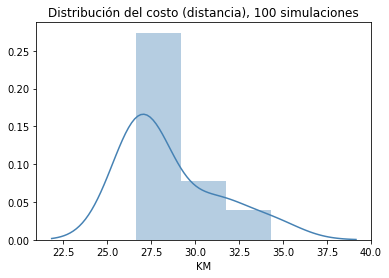

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.distplot(rutas.Costo, color="steelblue")
plt.title('Distribución del costo (distancia), 100 simulaciones')
plt.xlabel('KM', fontsize=10)

Text(0.5, 0, 'Tiempo')

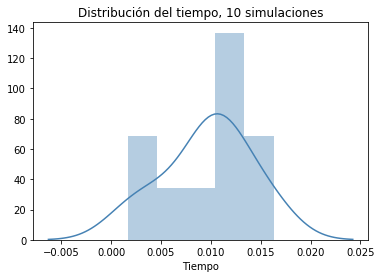

In [18]:
sns.distplot(rutas.Tiempo, color="steelblue")
plt.title('Distribución del tiempo, 10 simulaciones')
plt.xlabel('Tiempo', fontsize=10)

In [19]:
resumen = rutas.groupby('Ruta').size().reset_index(name='Count').rename(columns={'Col1':'Col_value'})
resumen

,Ruta,Count
0,10-5-3-8-6-9-12-4-13-14-11-1-7-2,1
1,10-5-8-3-6-9-12-4-11-14-13-1-7-2,1
2,10-5-8-3-6-9-12-4-13-11-14-1-7-2,1
3,10-5-8-3-6-9-12-4-13-14-11-1-7-2,2
4,10-5-8-3-6-9-12-4-14-11-13-1-7-2,1
5,14-13-3-2-8-5-12-7-1-6-10-9-4-11,1
6,14-5-8-3-6-9-12-4-13-11-10-2-7-1,2
7,6-8-3-5-10-9-12-4-13-14-11-1-7-2,1


In [20]:
import numpy as np
a = utest.split_tolist(resumen.loc[0, 'Ruta'])
a= list(np.int_(a))

b  =  utest.split_tolist(resumen.loc[3, 'Ruta'])
b= list(np.int_(b))

print(a) 
print(b)

[10, 5, 3, 8, 6, 9, 12, 4, 13, 14, 11, 1, 7, 2]
[10, 5, 8, 3, 6, 9, 12, 4, 13, 14, 11, 1, 7, 2]


#### Visualización de la ruta

In [21]:
mejor_ruta

[6, 8, 3, 5, 10, 9, 12, 4, 13, 14, 11, 1, 7, 2]

In [22]:
df2

,fza_ventas,id,lat,lon,posicion
1116,20240,11326,25.6409,-100.089,1
1116,20240,1008232009,25.5881,-100.012,2
1117,20240,1008232105,25.5797,-100.009,3
1118,20240,1008232217,25.5689,-100.028,4
1119,20240,1008232222,25.5773,-100.014,5
1120,20240,1008232223,25.5729,-100.009,6
1121,20240,1008232500,25.6323,-100.035,7
1122,20240,1008233352,25.5782,-100.010,8
1123,20240,1020211168,25.5772,-100.017,9
1124,20240,1020268099,25.5780,-100.016,10


In [23]:
utest.vis_mapa(df2, mejor_ruta)

### Ejemplo de dos rutas

In [25]:
import folium

In [26]:
# dos diferentes rutas
df0=df2.set_index('posicion')

# ruta 1
df1=df0.reindex(a)
coordenadas1 = df1[['lat', 'lon']].values.tolist()

df3=df0.reindex(b)
coordenadas2 = df3[['lat', 'lon']].values.tolist()


os = df0.loc[[1], ['lat', 'lon']].values.tolist()#Definición de punto: Oficina de servicio
cen_lon = df0.lon.mean()
cen_lat = df0.lat.mean()
mapi = folium.Map(location=[cen_lat,cen_lon],
                  zoom_start = 12,
                  tiles= "OpenStreetMap")
folium.PolyLine(coordenadas1 + [coordenadas1[0]],
                color='red',
                weight=2,
                opacity=0.8).add_to(mapi)
folium.Marker(os[0], icon=folium.Icon(color='blue', icon='cloud') ).add_to(mapi)

folium.PolyLine(coordenadas2 + [coordenadas2[0]],
                color='blue',
                weight=1.5,
                opacity=1).add_to(mapi)
#N = 14
#popups = [str(i) for i in range(14)] # Popups texts are simple numbers.

#plugins.MarkerCluster(coordenadas1, popups=popups).add_to(mapi)

mapi